In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import mean_squared_error as MSE
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
%matplotlib inline

Считаем данные

In [3]:
data = pd.read_csv('blogData_train.csv', names=range(281))
labels = np.array(data[280])
data = data[[i for i in range(280)]]

Категориальных признаков нет.

Разобьем выборку на обучающую и тестовую.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4)

# Задание 1

In [27]:
X_test.shape[0]

39298

## Среднеквадратичная ошибка

Немного переписанная для задачи регресии функция оценки среднеквадратичной ошибки в зависимости от количества деревьев.

In [25]:
def mse_by_tree_count(model, test, target_test):
    n_estimators = model.get_params()['n_estimators']
    mse_values = np.zeros(n_estimators)
    trees_labels = np.zeros((test.shape[0], n_estimators))
    for n in range(n_estimators):
        trees_labels[:, n] = model.estimators_[n].predict(test)
#        print(trees_labels[:, n])
        mse_values[n] = MSE([np.mean(labels) \
                                             for labels in trees_labels[:, :n + 1]],\
                                            target_test)
    return mse_values

In [45]:
%%time
rf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)

Wall time: 1min 23s


In [46]:
%%time
rf_values = mse_by_tree_count(rf, X_test, y_test)
rf_values_tr = mse_by_tree_count(rf, X_train, y_train)

Wall time: 50.4 s


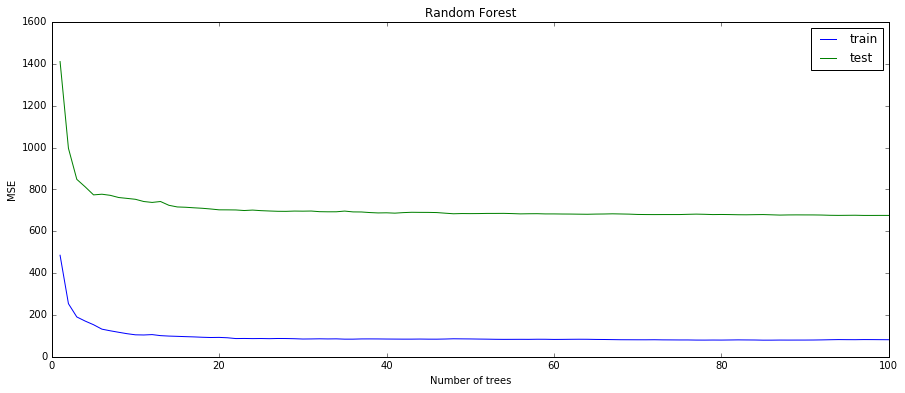

In [47]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(rf_values_tr)) + 1, rf_values_tr, label='train')
plt.plot(np.arange(len(rf_values)) + 1, rf_values, label='test')
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.title('Random Forest')
plt.legend()
plt.show()

Можно заметить, что после 40 деревьев качество построенной регресии практически не улучшается.

## Ошибка out-of-bag

In [26]:
def model_with_oob(train, target_tr, max_n_estimators):
    model = RandomForestRegressor(oob_score=True)
    oob_scores = []
    
    for n_estimators in range(1, 1 + max_n_estimators):
        model.set_params(n_estimators=n_estimators)
        model.fit(train, target_tr)
        oob_scores += [model.oob_score_]
        
    return model, np.array(oob_scores)

In [33]:
%%time
max_n_estimators = 70
model, oob_scores = model_with_oob(X_train, y_train, max_n_estimators)

C:\Users\MoYo_ZP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\MoYo_ZP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\MoYo_ZP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\MoYo_ZP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not

KeyboardInterrupt: 

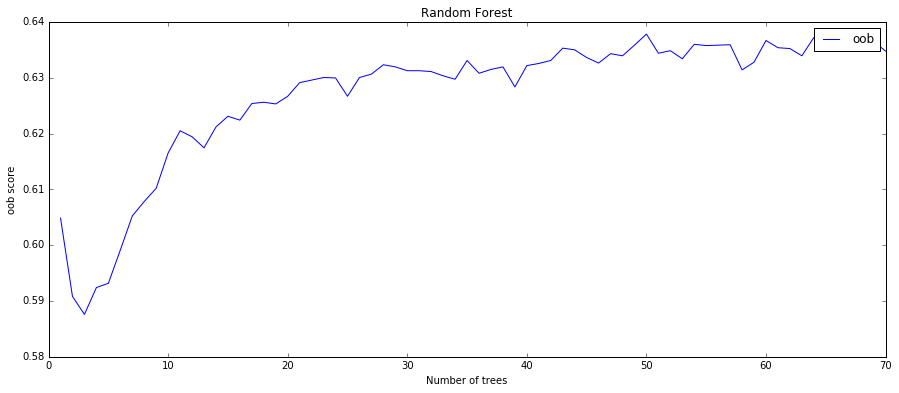

In [11]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(oob_scores)) + 1, oob_scores, label='oob')
plt.xlabel('Number of trees')
plt.ylabel('oob score')
plt.title('Random Forest')
plt.legend()
plt.show()

Качество oob_score значительно не уменьшается после 50 деревьев. Показатель oob_score более зашумлен, чем MSE.

# Задание 2

## Исследуем важность признаков

In [48]:
fi = rf.feature_importances_
fi_num = zip(fi, range(len(fi)))
sorted_fi_num = sorted(fi_num, reverse=True)

C:\Users\MoYo_ZP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


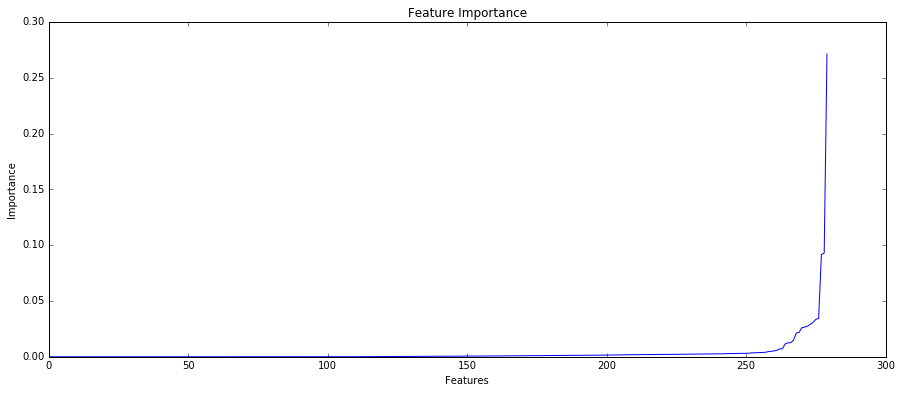

In [49]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(fi)), sorted(fi))
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.show()

In [50]:
sorted(fi)[-1]

0.27129319872934732

Самый лучший признак дает 27% качества.

В important_features запишем номера лучших признаков, которые в сумме дают не меньше 95% качества.

In [51]:
important_features = []
quality_sum = 0.
for feature in sorted_fi_num:
    if quality_sum < 0.95:
        quality_sum += feature[0]
        important_features.append(feature[1])

In [52]:
quality_sum

0.95127175078663395

In [53]:
len(important_features)

92

Получилось, что 92 из 280 признаков отвечают за 95% качества.

## Обучим модель только на этих 92 самых важных признаках

In [54]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [55]:
%%time
rf_fi = RandomForestRegressor(n_estimators=100).fit(X_train[important_features], y_train)

Wall time: 34.5 s


In [56]:
%%time
rf_fi_values_tr = mse_by_tree_count(rf_fi, X_train[important_features], y_train)

Wall time: 13 s


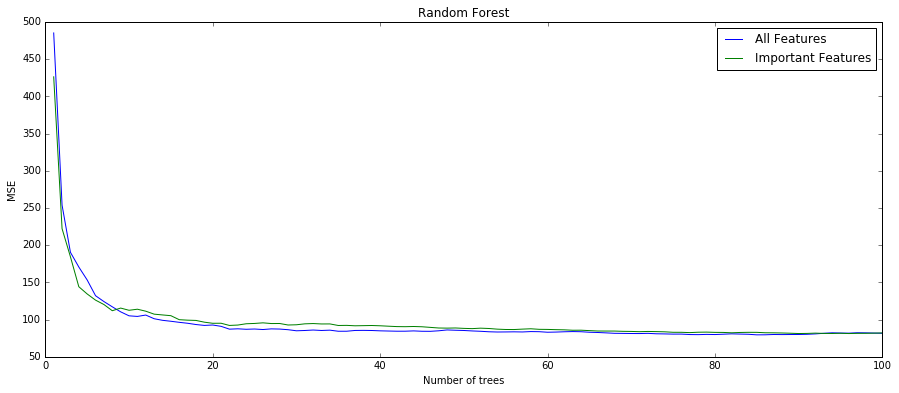

In [57]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(rf_values_tr)) + 1, rf_values_tr, label='All Features')
plt.plot(np.arange(len(rf_fi_values_tr)) + 1, rf_fi_values_tr, label='Important Features')
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.title('Random Forest')
plt.legend()
plt.show()

На небольшом количестве деревьев (<10) модель, обученная на важных признаках, дает меньшую квадратичную ошибку. При количестве деревьев от 10 до 80 ненамного лучше модель, построенная по всем признакам. При количестве деревьев, больше 80, разница практически не видна.(???)

# Задание 3

## Попробуем подобрать оптимальные значения параметров min_samples_split и max_features

In [64]:
%%time

max_estimators=100
mse = np.zeros([6, 6, max_estimators], dtype=float)

for i in range(1, 6):
    for j in range(1, 6):
        rf_model = RandomForestRegressor(n_estimators=max_estimators, min_samples_split=2*i,
                                           max_features=j*18).fit(X_train[important_features],
                                                                y_train)
        mse[i][j] = mse_by_tree_count(rf_model, X_test[important_features], y_test)

Wall time: 21min 44s


In [65]:
print(mse[:, : , -1])

[[   0.            0.            0.            0.            0.            0.        ]
 [   0.          651.15160713  655.38788415  658.31442963  673.79528491
   676.00360389]
 [   0.          651.35249726  650.69541105  659.89020144  661.14373496
   673.84117908]
 [   0.          648.49479324  651.26562733  651.98100605  670.4446422
   677.85247382]
 [   0.          651.0397566   648.66253532  655.99648161  666.71084318
   671.98685848]
 [   0.          651.13560833  644.53055301  659.87690654  667.72260986
   672.49286696]]


In [66]:
rf_values = mse_by_tree_count(rf_fi, X_test[important_features], y_test)

## Убедимся, что модели достаточно обучены

Для этого визуализируем зависимосто ошибки от количества деревьев для некоторых значений параметра и убедимся, что значения стабилизировались.

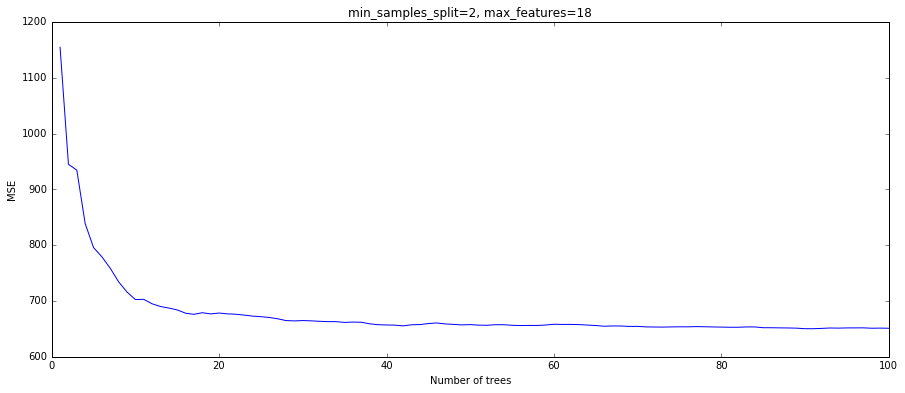

In [69]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(mse[1][1])) + 1, mse[1][1])
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.title('min_samples_split=2, max_features=18')
plt.show()

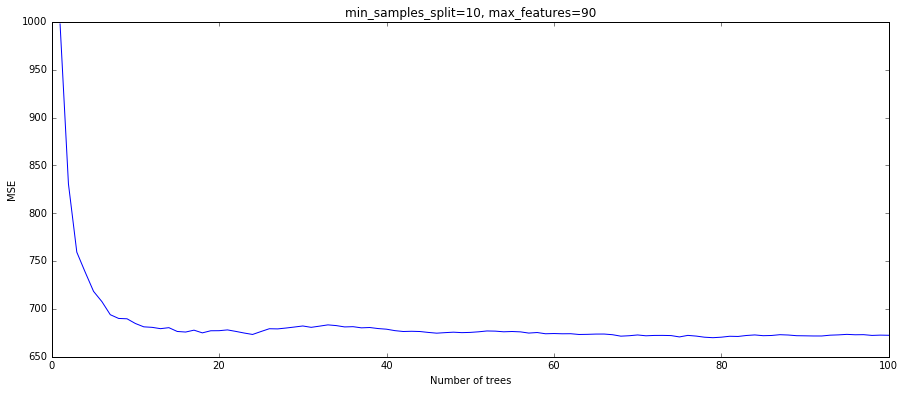

In [70]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(mse[5][5])) + 1, mse[5][5])
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.title('min_samples_split=10, max_features=90')
plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(mse[5][5])) + 1, mse[5][5])
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.title('min_samples_split=10, max_features=90')
plt.show()

Можно видеть, что графики стабилизируются после 80 деревьев.

Визуализируем матрицу ошибок.

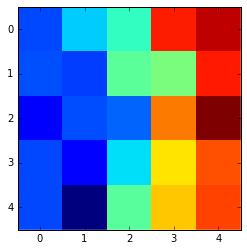

In [23]:
plt.imshow(mse[1:, 1: , -1], interpolation='none')

Лучшие результаты достигаются при значениях параметров min_samples_split=10 и max_features=36.

# Задание 4

Попробуем подобрать оптимальные значения параметров min_samples_split и max_features

## Релизация sklearn.ensemble.GradientBoostingRegressor

In [83]:
%%time

max_estimators=100
mse_gr_b = np.zeros([6, 6], dtype=float)
result = np.zeros([6, 6, len(y_test)], dtype=float)

for i in range(1, 6):
    for j in range(1, 6):
        rf_model = GradientBoostingRegressor(n_estimators=max_estimators, 
                                             min_samples_split=2*i, 
                                             max_features=j*18).fit(X_train, y_train)
        result[i][j] = rf_model.predict(X_test)
        mse_gr_b[i][j] = MSE(result[i][j], y_test)

CPU times: user 11min 23s, sys: 800 ms, total: 11min 23s
Wall time: 11min 24s


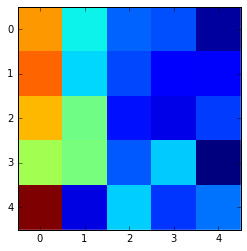

In [84]:
plt.imshow(mse_gr_b[1:, 1:], interpolation='none')

Лучшие результаты достигаются при значениях параметров min_samples_split=8 и max_features=90.

## Релизация xgboost

In [86]:
%%time

max_estimators=10
mse_gr_b = np.zeros([6, 6], dtype=float)
result = np.zeros([6, 6, len(y_test)], dtype=float)

for i in range(1, 6):
    for j in range(1, 6):
        rf_model = xgb(n_estimators=max_estimators, 
                                             min_samples_split=2*i, 
                                             max_features=j*18).fit(X_train, y_train)
        result[i][j] = rf_model.predict(X_test)
        mse_gr_b[i][j] = MSE(result[i][j], y_test)

TypeError: 'module' object is not callable

In [103]:
dtrain = xgb.DMatrix(X_train, label=y_train)

ValueError: all feature_names must be alphanumerics

In [104]:
dtest = xgb.DMatrix(X_test)

ValueError: all feature_names must be alphanumerics

In [95]:

param = {'objective':'multi:softmax', 'bst:max_depth':3, 'bst:eta':0.1, 'silent':1, 'nthread':4, 'num_class':7}
plst = param.items()

In [96]:
def xgboost_accuracy_scores(sample, true_targets): 
    return np.array([accuracy_score(true_targets,
                                    model.predict(sample, ntree_limit=n + 1)) 
                     for n in range(num_boost_round)])

In [98]:
%%time
num_boost_round = 100
model = xgb.train(plst, X_train, num_boost_round=num_boost_round)

TypeError: invalid cache item: DataFrame

In [97]:
%%time
num_boost_round = 100
model = xgb.train(plst, dtrain, num_boost_round=num_boost_round)

NameError: name 'dtrain' is not defined

In [ ]:
xgb_scores_train = xgboost_accuracy_scores(dtrain, y_train)
xgb_scores_test = xgboost_accuracy_scores(dtest, y_test)

plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(xgb_scores_train)) + 1, xgb_scores_train, label='xgb train')
plt.plot(np.arange(len(xgb_scores_test)) + 1, xgb_scores_test, label='xgb test')
plt.legend()
plt.show()

In [ ]:
%%time
num_boost_round = 1000
model = xgb.train(plst, dtrain, num_boost_round=num_boost_round)